## 店铺数据爬取

In [4]:
import GetShopInfo
import csv

get = GetShopInfo

In [5]:
with open("美食.csv", mode="a", encoding='utf-8', newline="") as f:
    csvFile = csv.DictWriter(f, fieldnames=['店铺ID', '店铺名', '店铺评论页', '店铺所在位置', '人均消费', '评分',
                                              '美食名称', '店铺图片链接', '纬度', '经度', '最低价格'])
    csvFile.writeheader()  # 写入表头
    # 搜索的页数
    for i in range(9):
        get.parseData(data=get.requestData(search='美食', page=i), csvFile=csvFile)

Page 0 Success
Page 1 Success
Page 2 Success
Page 3 Success
Page 4 Success
Page 5 Success
Page 6 Success
Page 7 Success
Page 8 Success


## 店铺数据分析

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['Microsoft YaHei']  

#### 文件数据读入
使用pandas读取信息并按列分开

In [8]:
df = pd.read_csv('美食.csv')
df.columns = ['店铺ID', '店铺名', '店铺评论页', '店铺所在位置', '人均消费', '评分',
                                              '美食名称', '店铺图片链接', '纬度', '经度', '最低价格']
print(df.shape[0])

288


#### 数据去重

In [10]:
df.drop_duplicates(subset=None, keep='first', inplace=True)
print(df.shape[0])

256


#### 价格与评分线性回归分析图
通过画出人均价格与评分之间的关系，我们可以清楚的观察到是否越贵的东西越好,同时也可以引入最低价格，从另一个方面观察它们之间的关系

线性回归分析图我们发现价格8-12的评分集中于高点，其它价格评分比较分散，线性方程计算而出的结果也显示价格高的奶茶评分较高；
而最低价格与评分关系并不大，线性方程也表明两者几乎无关。

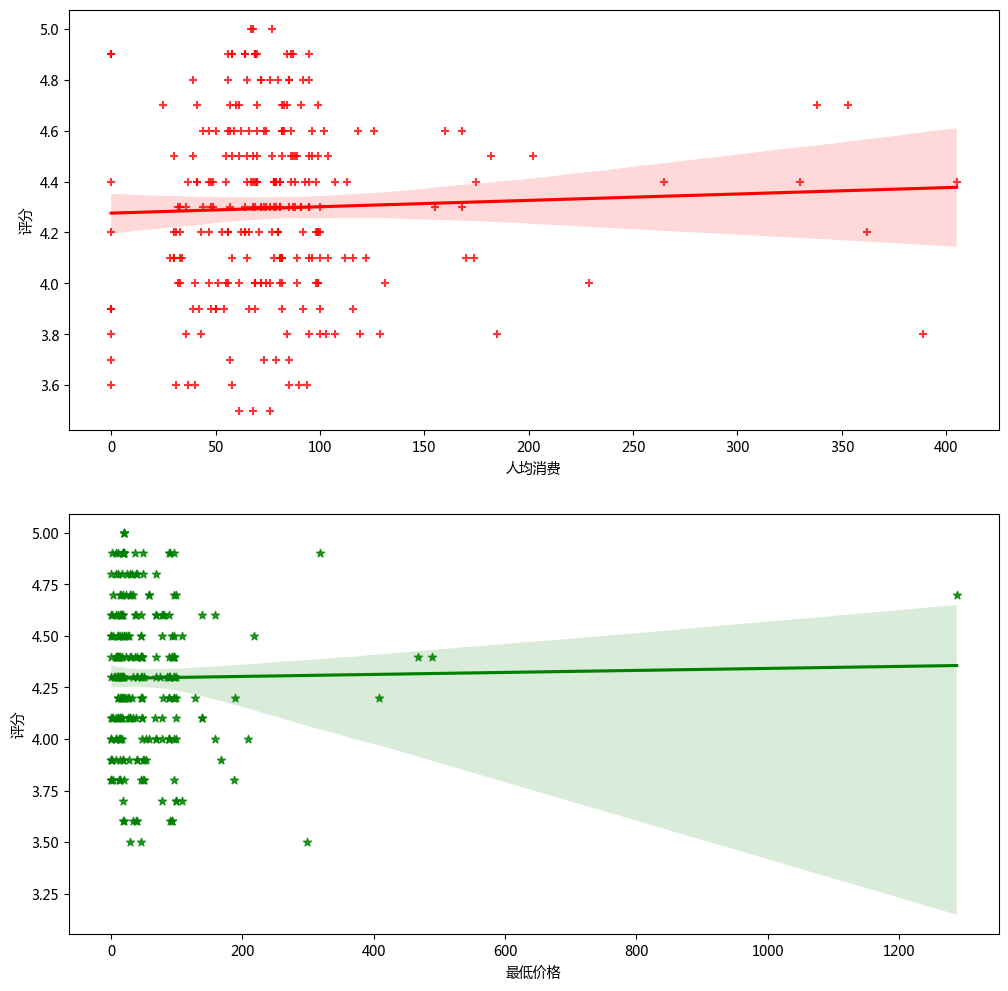

In [11]:
import seaborn as sns

# make data
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
sns.regplot(x='人均消费', y='评分', data=df, color='red', marker='+', ax=axes[0])
sns.regplot(x='最低价格', y='评分', data=df, color='green', marker='*', ax=axes[1])
plt.show()

#### 品牌统计
品牌可以从商店名中截取出来，使用集合、列表分别存储，成为之后的键值对。我们计算出各品牌出现次数并从高到低排序，再使用柱状图可视化呈现

##### 列表转字典函数
以集合的形式输入键，通过对传入的列表统计计算出值

In [12]:
def countDict(aSet: set, aList: list, minValue=0) -> dict:
    # 列表转为字典，统计出aSet中每个元素出现的次数
    aDict = {}
    for item in aSet:
        counter = aList.count(item)
        if counter >= minValue:  #去除仅出现一次的品牌，极有可能是商家打错了
            aDict[item] = aList.count(item)

    return aDict

In [13]:
# 传入数据
shopNames = df['店铺名']
# 品牌列表，将截取出的品牌名存入列表
brandList = []
# 品牌名使用集合存储，利用集合元素唯一性自动实现去重
brandSet = set()

for shopName in shopNames:
    # 店铺名一般是 “品牌（地址）” 的形式，通过中文符号'（'来截取出品牌
    index = shopName.find('（')  # 返回（的位置，未找到返回-1'
    # 三元表达式 ，如果没有（）就直接原样返回
    brand = shopName[:index] if index != -1 else shopName
    brandSet.add(brand)
    brandList.append(brand)

brandDict = countDict(brandSet, brandList, 2)

# 将字典按照元素值进行逆序排序
brandDict = dict(sorted(brandDict.items(), key=lambda i: i[1], reverse=True))

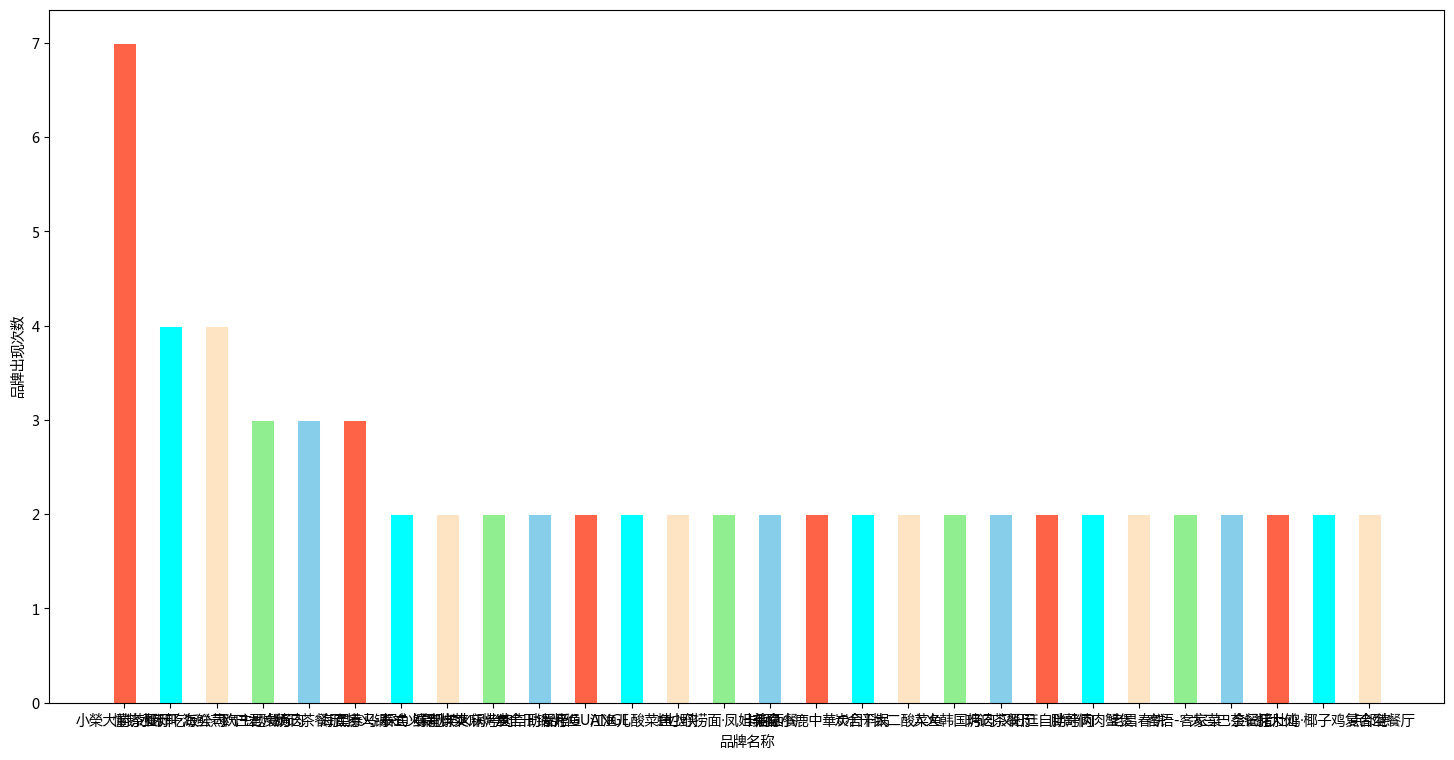

In [14]:
# make data:
x = brandDict.keys()
y = brandDict.values()

# plot
fig = plt.subplots(figsize=(18, 9))
colors = ['tomato', 'aqua', 'bisque', 'lightgreen', 'skyblue']
plt.bar(x, y, width=0.5, color=colors, edgecolor="white", linewidth=0.7)
plt.xlabel('品牌名称')
plt.ylabel('品牌出现次数')
plt.show()

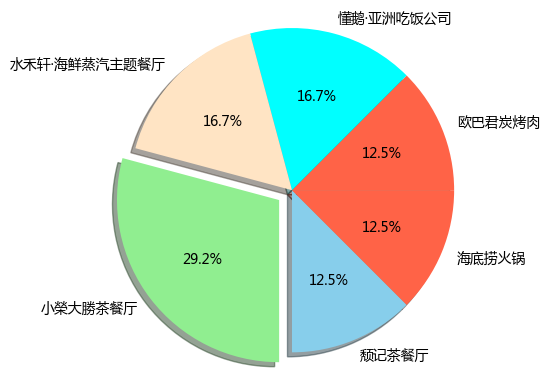

In [15]:
# 精简数据，仅采用出现三次以上的数据
brandDict = countDict(brandSet, brandList, 3)
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = brandDict.keys()
sizes = brandDict.values()
# only "explode" the 4nd slice (i.e. 'Hogs')
explode = [0 for _ in range(len(sizes))]
explode[3] = 0.1
colors = ['tomato', 'aqua', 'bisque', 'lightgreen', 'skyblue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### 地点统计
店铺名称中通常含有地址，正事中文括号中的部分，我们同样可以通过字符串截取出地址，但由于个别商店格式并非如此，可能会出现未填地址的情况，则会直接跳过

In [16]:
# 传入数据
shopNames = df['店铺名']
# 品牌列表，将截取出的品牌名存入列表
placeList = []
# 品牌名使用集合存储，利用集合元素唯一性自动实现去重
placeSet = set()

for shopName in shopNames:
    # 店铺名一般是 “品牌（地址）” 的形式，通过中文符号'（'来截取出品牌
    index = shopName.find('（')  # 返回（的位置，未找到返回-1'
    if index != -1:
        place = shopName[index + 1:-1]
        placeSet.add(place)
        placeList.append(place)

placeDict = countDict(placeSet, placeList, 2)

# 将字典按照元素值进行逆序排序
placeDict = dict(sorted(placeDict.items(), key=lambda i: i[1], reverse=False))
placeData = pd.DataFrame({'地点': [x for x in placeDict.keys()],
                          '出现次数': [x for x in placeDict.values()]})

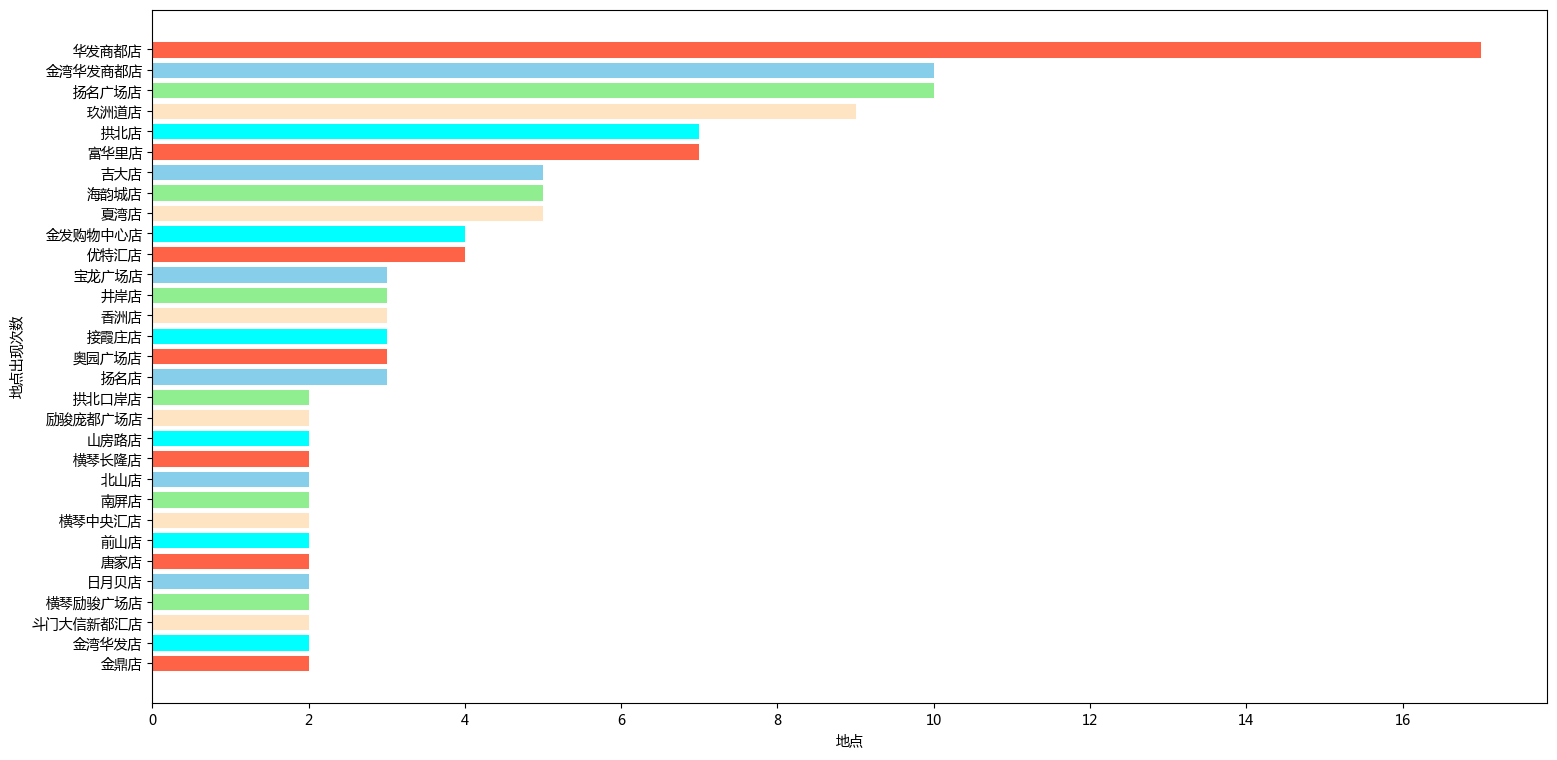

In [17]:
# make data: 竖行柱状图
x = placeData['地点']
y = placeData['出现次数']

# plot
fig = plt.subplots(figsize=(18, 9))
colors = ['tomato', 'aqua', 'bisque', 'lightgreen', 'skyblue']
plt.barh(x, y, color=colors, edgecolor="white", linewidth=0.7)
plt.xlabel('地点')
plt.ylabel('地点出现次数')
plt.show()

#### 店铺位置模拟
我们获取了近300家店铺的经纬度信息，虽然我们暂时无法直接定位到地图上，但我们可以画出经纬度散点图，来大致推断出哪里奶茶店较多。
合肥所在地区的纬度大约为北纬32°，不同纬度间距相同都是1纬度约110.94，北纬32°处的纬度周长为40075×sin(90-32)，因此此处的1纬度约为94.40
经纬度比例为1.1752。通过计算得出，在画布长宽都代表1.2°时画布设置为20×17时比例1.1764较为接近，误差仅有1.08%
在将我们所在位置带入散点图，即可发现奶茶店大多在我们的东方、北方，这与城市发展状况也较为符合

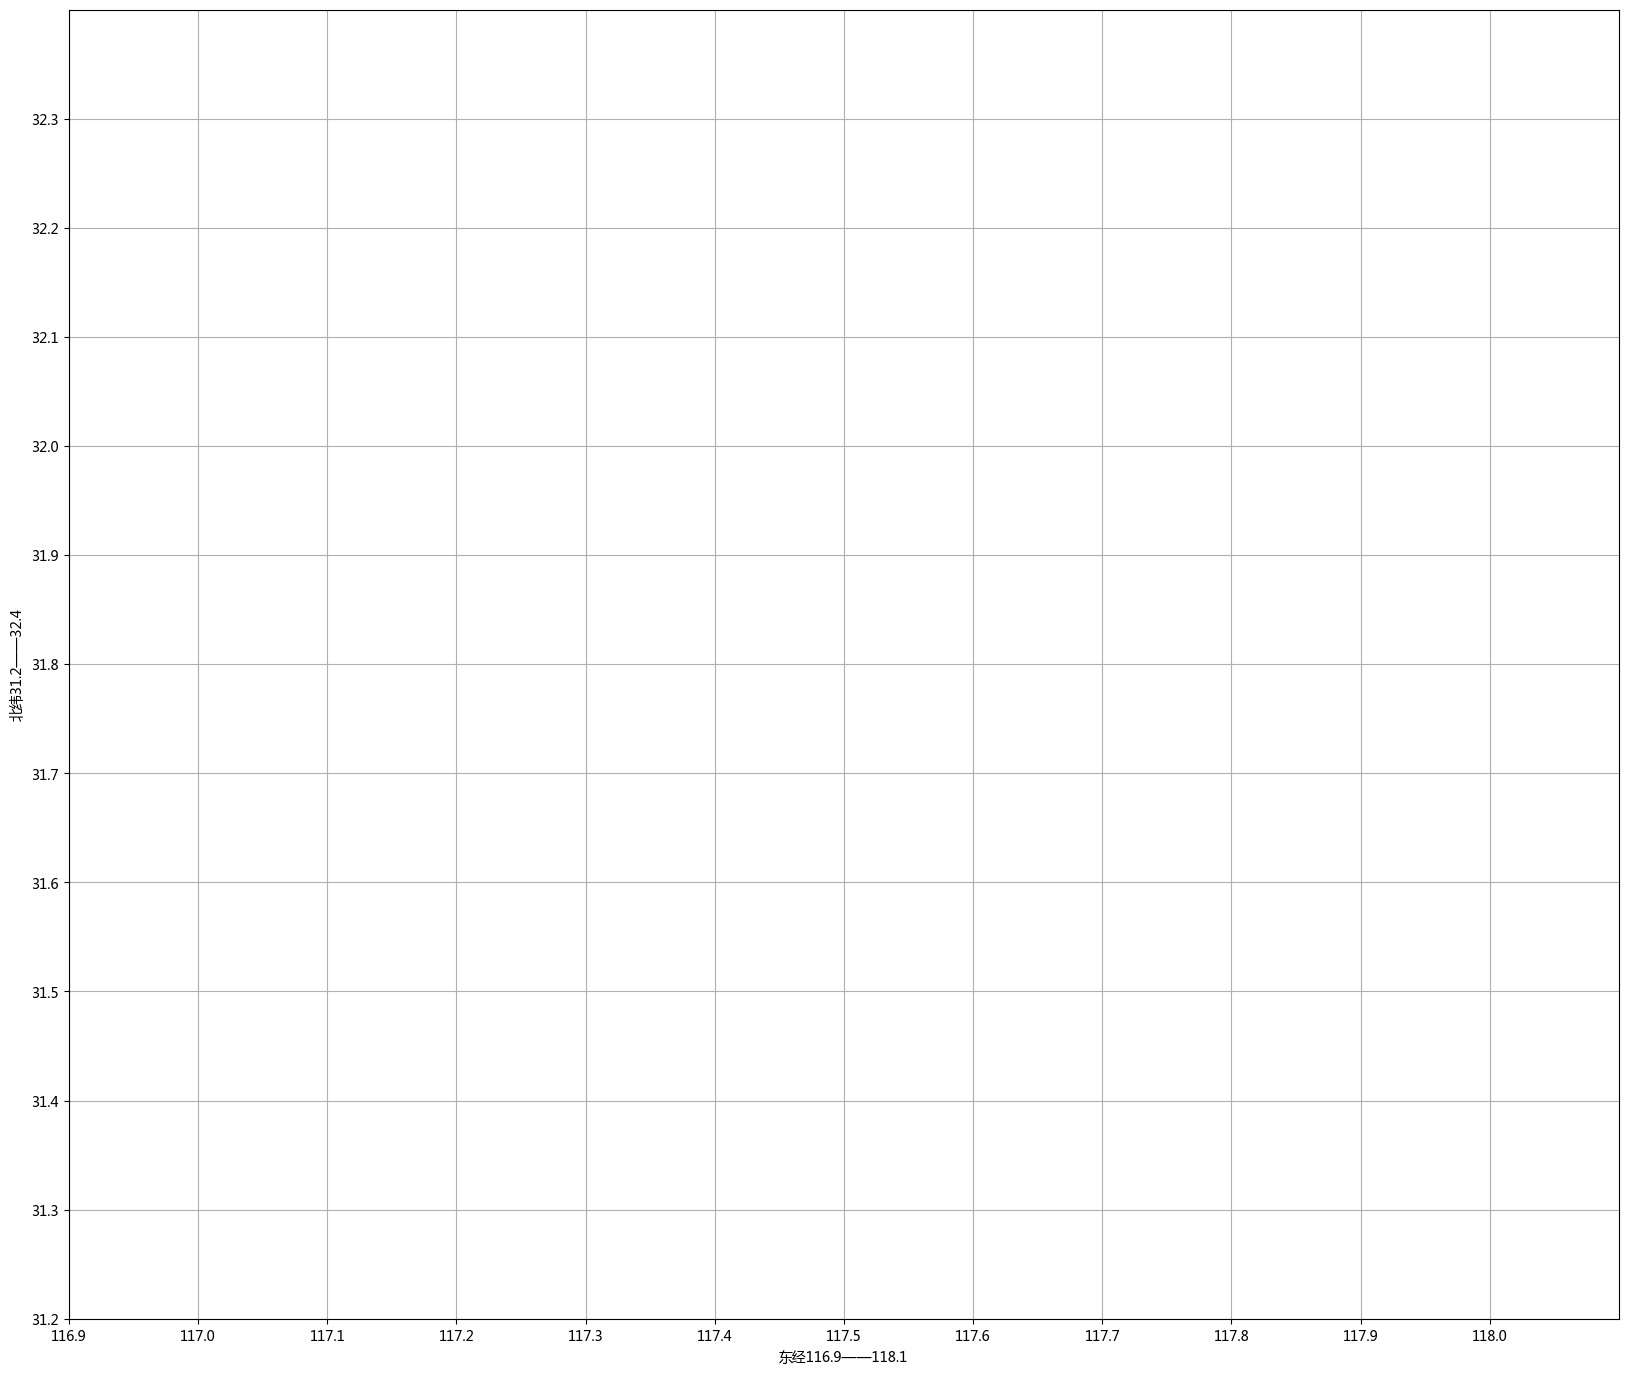

In [18]:
# make the data
# 获取经纬度信息
longitude = df['经度']
latitude = df['纬度']
# size and color:
sizes = np.random.uniform(15, 80, len(longitude))
colors = np.random.uniform(15, 80, len(latitude))

# plot
fig, ax = plt.subplots(figsize=(20, 17))

ax.scatter(x=longitude, y=latitude, s=sizes, c=colors, vmin=0, vmax=100)

ax.set(xlim=(116.9, 118.1), xticks=np.arange(116.9, 118.1, 0.1),
       ylim=(31.2, 32.4), yticks=np.arange(31.2, 32.4, 0.1))
# 是否显示网格，默认不显示
ax.grid(True)
ax.set_xlabel("东经116.9——118.1")
ax.set_ylabel("北纬31.2——32.4")
plt.show()